In [1]:
import os
import numpy as np
import gzip
import collections
import sys
sys.path.append('/usr/users/fsimone/tejaas')
from iotools import readgtf
from utils import cismasking

sys.path.append('../../')
import operator
import json
from utils import utils
json_file = "../../gtex_v8_metadata.json"
tissue_file = "/usr/users/fsimone/trans-eqtl-pipeline/analysis/plots/tissue_table.txt"
tshorts, tfulls_plain = utils.read_tissues(tissue_file, plain=True)
_, tfulls = utils.read_tissues(tissue_file)
with open(json_file) as instream:
    gtex_meta = json.load(instream)
tissue_colors  = dict()
tissue_names   = dict()
tissue_samples = dict()
for tshort, tfull in zip(tshorts, tfulls_plain):
    tissue_names[tshort] = tfull
for tshort, tfull in zip(tshorts, tfulls):
    tissue_colors[tshort] = "#" + gtex_meta[tfull.replace(" ", "_")]["colorHex"]
    tissue_samples[tshort] = gtex_meta[tfull.replace(" ", "_")]["rnaSeqAndGenotypeSampleCount"]

brain_tissues = ['bam','ban','bca','bceh','bce','bco','bfr','bhi','bhy','bnu','bpu','bsp','bsu']   
optim_tissues = ['haa', 'pan', 'spl', 'wb']



In [2]:
base_dir = "/cbscratch/franco/datasets"
gtffile = os.path.join(base_dir, "GENCODE/gencode.v26.annotation.gtf.gz")
genemapfile  = os.path.join(base_dir, "crossmappability/hg38_gene_mappability.txt.gz")
crossmapfile = os.path.join(base_dir, "crossmappability/hg38_cross_mappability_strength.txt.gz")

In [3]:
SNPINFO_FIELDS = ['chrom', 'varid', 'bp_pos', 'ref_allele', 'alt_allele', 'maf']
class SnpInfo(collections.namedtuple('_SnpInfo', SNPINFO_FIELDS)):
    __slots__ = ()

    
def Snp2info(snps_list):
    snpinfo = list()
    for snpid in snps_list:
        arr = snpid.split("_")
        chrom = int(arr[0][3:])
        pos = int(arr[1])
        this_snp = SnpInfo(chrom      = chrom,
                           bp_pos     = pos,
                           varid      = snpid,
                           ref_allele = "X",
                           alt_allele = "Y",
                           maf        = None)
        snpinfo.append(this_snp)
    return snpinfo
    
def extend_cismask(genes, cismaskcomp, cross_gene_dict):
    # cross_gene_dict = read_crossmap(crossmapfile)
    genes_ix_dict = dict(zip([x.ensembl_id for x in genes], np.arange(len(genes))))
    crossmap_cismaskcomp = list()
    for cismask in cismaskcomp:
        gene_list = list()  # list of crossmapped genes for the cismask
        for gene in [genes[i] for i in cismask.rmv_id]:
            gene_list += cross_gene_dict[gene.ensembl_id]
        uniq_gene_list = list(set(gene_list))
        ugene_dict = collections.defaultdict(lambda: False) # significant speed-up by making a dict
        for g in uniq_gene_list:
            ugene_dict[g] = True
        cm_gene2rmv_ix = [genes_ix_dict[x.ensembl_id] for x in genes if ugene_dict[x.ensembl_id]]
        if len(cm_gene2rmv_ix) > 0:
            new_mask_genes = sorted(list(set(list(cismask.rmv_id) + cm_gene2rmv_ix)))
            new_cismask = cismask._replace(rmv_id = np.array(new_mask_genes))
            crossmap_cismaskcomp.append(new_cismask)
        else:
            crossmap_cismaskcomp.append(cismask)
    return crossmap_cismaskcomp

def read_tissue_genes(gx_file, geneinfo_dict):
    genes = list()
    with open(gx_file) as inst:
        next(inst)
        for line in inst:
            ensembl_id = line.split()[0]
            genes.append(geneinfo_dict[ensembl_id])
    return genes

def read_crossmap(crossmapfile):
    gene_pairs = collections.defaultdict(list)
    with gzip.open(crossmapfile, 'r') as instream:
        for line in instream:
            arr = line.rstrip().split()
            gene_pairs[arr[0].decode('utf-8')].append(arr[1].decode('utf-8'))
    return gene_pairs

cross_gene_dict = read_crossmap(crossmapfile) 

In [4]:
geneinfo = readgtf.gencode(gtffile, trim=False)

In [5]:
import mpmath
mpmath.mp.dps = 50
def pvalue(x): return float(mpmath.log10(1 - 0.5 * (1 + mpmath.erf(x/mpmath.sqrt(2)))))

SNPRES_FIELDS = ['rsid', 'chrom', 'pos', 'logp', 'maf']
class SNPRes(collections.namedtuple('_SNPRes', SNPRES_FIELDS)):
    __slots__ = ()
    
def tejaas(filepath):
    res = list()
    with open(filepath, 'r') as mfile:
        next(mfile)
        for line in mfile:
            arr   = line.strip().split("\t")
            rsid  = arr[0]
            chrom = int(arr[1])
            pos   = int(arr[2])
            maf   = float(arr[3])
            q     = float(arr[4])
            mu    = float(arr[5])
            sigma = float(arr[6])
            p     = float(arr[7])
            if sigma == 0:
                continue
            logp  = np.log10(p) if p != 0 else pvalue( (q - mu) / sigma)
            res.append(SNPRes(rsid=rsid, chrom=chrom, pos=pos, logp=-logp, maf=maf))
    return res

base_resdir = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_SHAPEIT2/raw/gtex_v8-aa/tejaas/permnull_sb0.1_knn30_crossmap/chr1/rr.txt"

target_file    = "trans_eqtls.txt.ld_prune"

## SHAPEIT 2 data
path_sb01    = "/cbscratch/franco/trans-eqtl/protein_coding_lncRNA_gamma01_knn30_cut5e-8/"
path_sb0006  = "/cbscratch/franco/trans-eqtl/protein_coding_lncRNA_gamma0006_knn30_cut5e-8/"
path_raw     = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_SHAPEIT2/raw/summary_5e-08/"


teqtls        = os.path.join(path_sb01, "{:s}/trans_eqtls_ldpruned.txt") 
teqtls_cm     = os.path.join(path_raw, "{:s}/tejaas", "permnull_sb0.1_knn30_crossmap", target_file)
alt_teqtls        = os.path.join(path_sb0006, "{:s}/trans_eqtls_ldpruned.txt") 
alt_teqtls_cm     = os.path.join(path_raw, "{:s}/tejaas", "permnull_sb0.006_knn30_crossmap", target_file)

teqtl_dict = collections.defaultdict(dict)
for ts in tshorts:
    if ts not in brain_tissues:
        if ts in optim_tissues:
            teqtl_dict["sb"][ts] = tejaas(alt_teqtls.format(ts))
            teqtl_dict["cm"][ts] = tejaas(alt_teqtls_cm.format(ts))
        else:
            teqtl_dict["sb"][ts] = tejaas(teqtls.format(ts))
            teqtl_dict["cm"][ts] = tejaas(teqtls_cm.format(ts))


# Set of total trans-eQTLs discovered across tissues

In [6]:
unique_set = collections.defaultdict(set)
for ts in tshorts:
    if ts not in brain_tissues:
        if ts not in optim_tissues:
            unique_set["sb"].update(set([x.rsid for x in teqtl_dict["sb"][ts]]))
            unique_set["cm"].update(set([x.rsid for x in teqtl_dict["cm"][ts]]))
            
configs = list(unique_set.keys())
for conf in configs:
    print(f"{conf}: {len(unique_set[conf])}")

sb: 11161
cm: 8324


# Read p-vals for all tissues for all SNPs, subset tissues

In [7]:
import pandas as pd

cm_allpval_file = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_SHAPEIT2/all_variants_pvalues_tejaas_4optims_crossmap.txt"
pval_df_cm = pd.read_csv(cm_allpval_file, header=0, index_col=0, sep="\t")

allpval_file = "/cbscratch/franco/from_saikat/gtex_v8_202003/all_variants_pvalues_tejaas_4optims.txt"
pval_df = pd.read_csv(allpval_file, header=0, index_col=0, sep="\t")

In [8]:
print(pval_df_cm.shape)
print(pval_df.shape)

tissues_set = [x for x in tshorts if x not in brain_tissues]
pval_df_cm_subset = pval_df_cm[tissues_set]
pval_df_subset = pval_df[tissues_set]

print(pval_df_cm_subset.shape)
print(pval_df_subset.shape)


(8048655, 38)
(8048655, 49)
(8048655, 36)
(8048655, 36)


# Read genes expressed in a tissue and calculate cismasks
## Cismasks with and without crossmappability filter

In [9]:
### reformat gene info
geneinfo_dict = dict()
for g in geneinfo:
    geneinfo_dict[g.ensembl_id] = g

# Obtain data for each tissue
## Nº filtered, brought in, average nº genes filtered in both sets

In [16]:
# import matplotlib.pyplot as plt
# from utils import mpl_stylesheet
# mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 18, colors = 'banskt')

global_cutoff = -np.log10(5e-8)

with open("crossmappability_teqtls_results_summary.txt", 'w') as outst:
    outst.write(f"tissue\ttotal_before\ttotal_after\tfiltered_out\tbrought_in\tmean_gdiff_filtered_out\tmean_gdiff_brought_in\n")
    for ts in tissues_set:
        print(ts)
        gx_file = f"/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_freeze/gtex_v8/expression/tpms/{ts}_tpms_qcfilter.txt.protein_coding_lncRNA_filtered"
        snpids    = [x.rsid for x in teqtl_dict["sb"][ts]]
        snpids_cm = [x.rsid for x in teqtl_dict["cm"][ts]]

        both_sets = list(set(snpids + snpids_cm))

        logpvals    = pval_df_subset[ts][both_sets]
        logpvals_cm = pval_df_cm_subset[ts][both_sets]

        snpinfo_tissue = Snp2info(both_sets)
        ts_genes       = read_tissue_genes(gx_file, geneinfo_dict)

        #### Obtain cismasks and add crossmappable genes
        cismasklist = cismasking.get_cismasklist(snpinfo_tissue, ts_genes, None, window=1e6)
        cismaskcomp = cismasking.compress_cismasklist(cismasklist)
        crossmap_cismaskcomp = extend_cismask(ts_genes, cismaskcomp, cross_gene_dict)

        gene_diffs = np.zeros(len(snpinfo_tissue))
        for i in range(len(cismaskcomp)):
            gene_diffs[cismaskcomp[i].apply2] = len(crossmap_cismaskcomp[i].rmv_id) - len(cismaskcomp[i].rmv_id)

        notsig_after_cm    = np.sum(logpvals_cm < global_cutoff)
        sig_after_cm       = np.sum(logpvals < global_cutoff)
        total_teqtl_before = np.sum(logpvals > global_cutoff)
        total_teqtl_after  = np.sum(logpvals_cm > global_cutoff)
        bar_heights        = [total_teqtl_before, total_teqtl_after, notsig_after_cm, sig_after_cm]
        notsig_after_cm_ix = logpvals_cm < global_cutoff
        sig_after_cm_ix    = logpvals < global_cutoff
        mean_gdiffs_notsig = np.mean(gene_diffs[notsig_after_cm_ix])
        mean_gdiffs_sig    = np.mean(gene_diffs[sig_after_cm_ix])

        outst.write(f"{ts}\t{bar_heights[0]}\t{bar_heights[1]}\t{bar_heights[2]}\t{bar_heights[3]}\t{mean_gdiffs_notsig:.2f}\t{mean_gdiffs_sig:.2f}\n")

as
av
ag
aa
ac
at
br
ebv
fib
cols


/usr/users/fsimone/opt/miniconda/3/envs/pyenv37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/users/fsimone/opt/miniconda/3/envs/pyenv37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


colt
esog
esom
esomu
haa
hlv
kc
liv
lu
msg


/usr/users/fsimone/opt/miniconda/3/envs/pyenv37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/users/fsimone/opt/miniconda/3/envs/pyenv37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ms
nt
ov
pan
pit


/usr/users/fsimone/opt/miniconda/3/envs/pyenv37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/users/fsimone/opt/miniconda/3/envs/pyenv37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


pro
snse
sse
si
spl
sto
tes
thy
ut
va


/usr/users/fsimone/opt/miniconda/3/envs/pyenv37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/users/fsimone/opt/miniconda/3/envs/pyenv37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


wb


In [44]:
# import pandas as pd
# test = [["as", 1000, 800, 200, 10, 6000, 5000], ["aa", 2000, 400, 300, 20, 7000, 4000],["wb", 2000, 4000, 5, 1800, 7000, 4000]]
# headerstr ="tissue\ttotal_before\ttotal_after\tfiltered_out\tbrought_in\tmean_gdiff_filtered_out\tmean_gdiff_brought_in"
# res_dict = dict()
# for l in test:
#     res_dict[l[0]] = dict(zip(headerstr.split("\t")[1:], l[1:]))
# res_dict

In [17]:
### Read data file above

res_dict = dict()
with open("crossmappability_teqtls_results_summary.txt") as inst:
    headerstr = inst.readline()
    headers   = headerstr.rstrip().split("\t")[1:]
    for line in inst:
        l = line.rstrip().split("\t")
        res_dict[l[0]] = dict(zip(headers, [float(x) for x in l[1:]]))
res_dict

{'as': {'total_before': 612.0,
  'total_after': 408.0,
  'filtered_out': 219.0,
  'brought_in': 15.0,
  'mean_gdiff_filtered_out': 6467.57,
  'mean_gdiff_brought_in': 6036.07},
 'av': {'total_before': 487.0,
  'total_after': 306.0,
  'filtered_out': 198.0,
  'brought_in': 17.0,
  'mean_gdiff_filtered_out': 6464.1,
  'mean_gdiff_brought_in': 5964.94},
 'ag': {'total_before': 192.0,
  'total_after': 142.0,
  'filtered_out': 52.0,
  'brought_in': 2.0,
  'mean_gdiff_filtered_out': 6465.62,
  'mean_gdiff_brought_in': 5153.0},
 'aa': {'total_before': 1376.0,
  'total_after': 986.0,
  'filtered_out': 412.0,
  'brought_in': 22.0,
  'mean_gdiff_filtered_out': 6279.07,
  'mean_gdiff_brought_in': 5312.86},
 'ac': {'total_before': 1618.0,
  'total_after': 1271.0,
  'filtered_out': 372.0,
  'brought_in': 25.0,
  'mean_gdiff_filtered_out': 6417.63,
  'mean_gdiff_brought_in': 5767.88},
 'at': {'total_before': 424.0,
  'total_after': 355.0,
  'filtered_out': 99.0,
  'brought_in': 30.0,
  'mean_gdiff_f

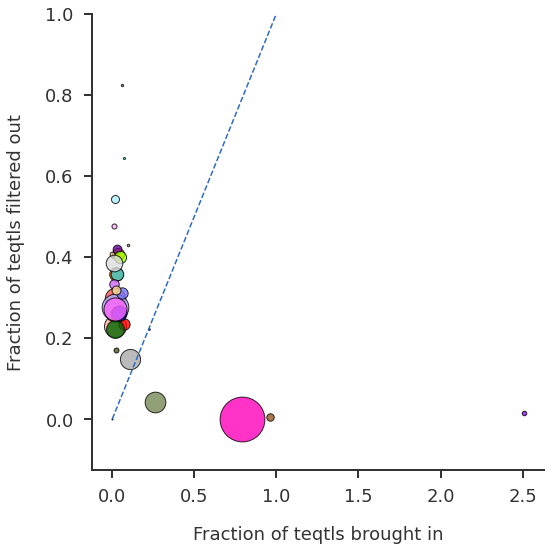

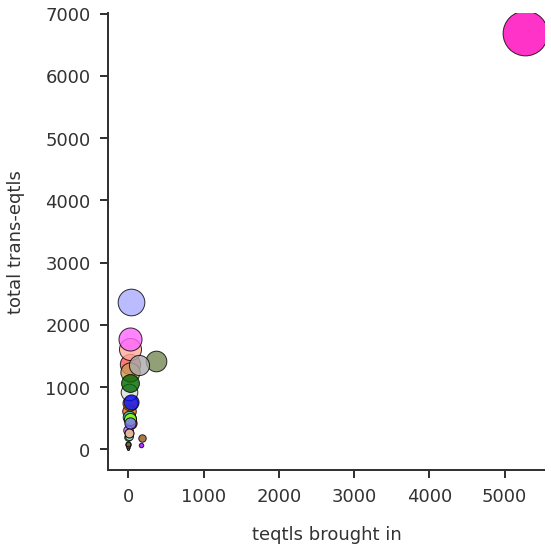

In [37]:
import matplotlib.pyplot as plt
from utils import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 18, colors = 'banskt')


res_dict ## will contain a dict with the table above
x_frac_brin = list()
y_frac_fout = list()
ts_indata = list()
for ts in tshorts:
    if ts not in brain_tissues:
        if ts not in res_dict:
            print(f"{ts} not in dataset")
            continue
        else:
            if res_dict[ts]["total_before"] != 0:
                x_frac_brin.append(res_dict[ts]["brought_in"]  /res_dict[ts]["total_before"])
                y_frac_fout.append(res_dict[ts]["filtered_out"]/res_dict[ts]["total_before"])
                ts_indata.append(ts)

ts_color = dict()
ed_color = dict()
ts_alpha = dict()
ts_size  = dict()
pval_c = 0.05
for ts in ts_indata:
    ts_color[ts] = tissue_colors[ts]
    ts_alpha[ts] = 0.9
    ed_color[ts] = "face"
    ts_size[ts]  = res_dict[ts]["total_before"] * 0.3
    
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
for i, ts in enumerate(ts_indata):
    ax1.scatter(x_frac_brin[i], y_frac_fout[i], s=ts_size[ts], color=ts_color[ts], edgecolor = 'black', alpha = 0.8)
ax1.plot([0,max(x_frac_brin+y_frac_fout)],[0,max(x_frac_brin+y_frac_fout)], linestyle="--")
ax1.set_xlabel("Fraction of teqtls brought in")
ax1.set_ylabel("Fraction of teqtls filtered out")
ax1.set_ylim(bottom=None,top=1)

plt.tight_layout()
plt.show()


fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
for i, ts in enumerate(ts_indata):
    ax1.scatter(res_dict[ts]["brought_in"], res_dict[ts]["total_before"], s=ts_size[ts], color=ts_color[ts], edgecolor = 'black', alpha = 0.8)
ax1.set_xlabel("teqtls brought in")
ax1.set_ylabel("total trans-eqtls")

plt.tight_layout()
plt.show()


In [28]:
tissue_samples['esom']

497

## Generate plots for each tissue

/usr/users/fsimone/tejaas/utils/mpl_stylesheet.py:26: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  r'\usepackage{microtype}',


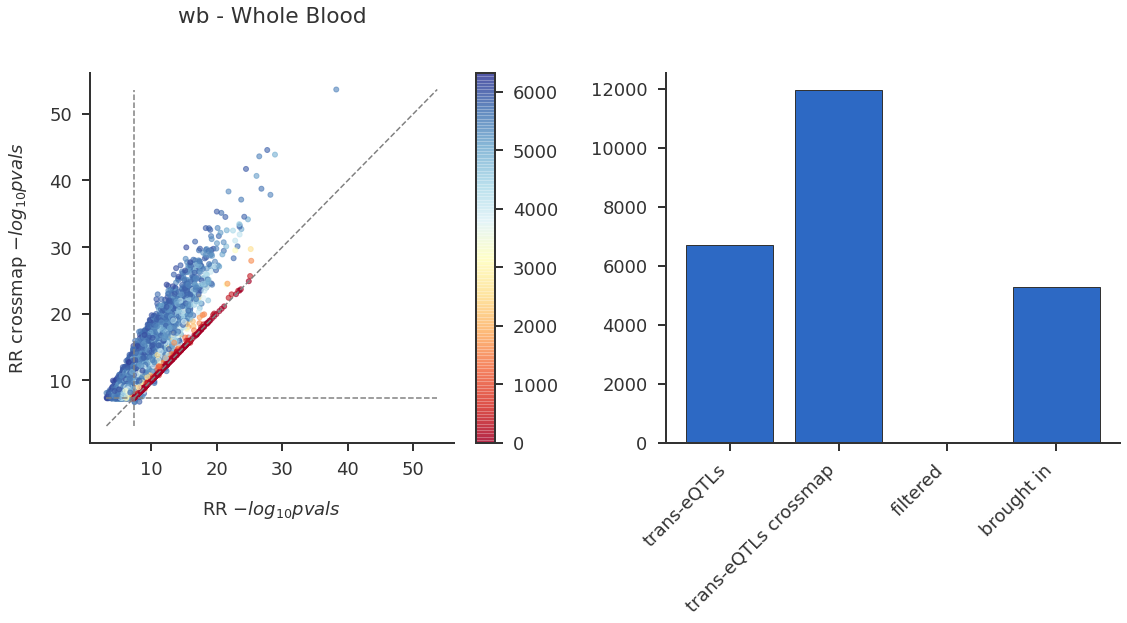

In [131]:
import matplotlib.pyplot as plt
from utils import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 18, colors = 'banskt')

global_cutoff = -np.log10(5e-8)
# for ts in tissues_set:
for ts in ['wb']:
    gx_file   = f"/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_freeze/gtex_v8/expression/tpms/{ts}_tpms_qcfilter.txt.protein_coding_lncRNA_filtered"
    snpids    = [x.rsid for x in teqtl_dict["sb"][ts]]
    snpids_cm = [x.rsid for x in teqtl_dict["cm"][ts]]
    
    both_sets = list(set(snpids + snpids_cm))
    
    logpvals    = pval_df_subset[ts][both_sets]
    logpvals_cm = pval_df_cm_subset[ts][both_sets]
    
    snpinfo_tissue = Snp2info(both_sets)
    ts_genes       = read_tissue_genes(gx_file, geneinfo_dict)
    
    #### Obtain cismasks and add crossmappable genes
    cismasklist = cismasking.get_cismasklist(snpinfo_tissue, ts_genes, None, window=1e6)
    cismaskcomp = cismasking.compress_cismasklist(cismasklist)
    crossmap_cismaskcomp = extend_cismask(ts_genes, cismaskcomp, cross_gene_dict)
    
    gene_diffs = np.zeros(len(snpinfo_tissue))
    for i in range(len(cismaskcomp)):
        gene_diffs[cismaskcomp[i].apply2] = len(crossmap_cismaskcomp[i].rmv_id) - len(cismaskcomp[i].rmv_id)
            
    cmap = plt.cm.get_cmap('RdYlBu')
    fig = plt.figure(figsize=(16,9))
    ax1 = fig.add_subplot(121)
    p1 = ax1.scatter(logpvals, logpvals_cm, c=gene_diffs, cmap=cmap, alpha=0.6, s=25)
    ax1.set_xlabel("RR $-log_{10} pvals$")
    ax1.set_ylabel("RR crossmap $-log_{10} pvals$")
    if len(logpvals_cm) > 0 or len(logpvals) > 0:
        m = np.min([logpvals_cm, logpvals])
        M = np.max([logpvals_cm, logpvals])
    else:
        m = 0
        M = 0
    ax1.plot([m,M], [m,M], color='gray', linestyle='dashed')
    ax1.vlines(global_cutoff, m, M, color='gray', linestyle="dashed")
    ax1.hlines(global_cutoff, m, M, color='gray', linestyle="dashed")
    ax1.set_title(f"{ts} - {tissue_names[ts]}")
    fig.colorbar(p1, ax=ax1)
    
    ax2 = fig.add_subplot(122)
    notsig_after_cm = np.sum(logpvals_cm < global_cutoff)
    sig_after_cm = np.sum(logpvals < global_cutoff)
    bar_heights = [np.sum(logpvals > global_cutoff), np.sum(logpvals_cm > global_cutoff), notsig_after_cm, sig_after_cm]
    ax2.bar([1,2,3,4], bar_heights) #, tick_label=)
    ax2.set_xticks([1,2,3,4])
    ax2.set_xticklabels(labels=["trans-eQTLs", "trans-eQTLs crossmap", "filtered", "brought in"], rotation = 45, ha="right")

    plt.tight_layout()
    plt.savefig(f"plots/{ts}_crossmap_pvalues.jpg", dpi=300)
    plt.show()

# For wb tissue, selects SNPs that are brought in
## How many genes are filtered by cross-mappability?
## 

In [227]:
ts = 'as'
snpids =    [x.rsid for x in teqtl_dict["sb"][ts]]
snpids_cm = [x.rsid for x in teqtl_dict["cm"][ts]]
both_sets = list(set(snpids + snpids_cm))
snpinfo_tissue = Snp2info(both_sets)

gx_file = f"/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_freeze/gtex_v8/expression/tpms/{ts}_tpms_qcfilter.txt.protein_coding_lncRNA_filtered"
ts_genes = read_tissue_genes(gx_file, geneinfo_dict)

cismasklist = cismasking.get_cismasklist(snpinfo_tissue, ts_genes, None, window=1e6)
cismaskcomp = cismasking.compress_cismasklist(cismasklist)
crossmap_cismaskcomp = extend_cismask(ts_genes, cismaskcomp, cross_gene_dict)

In [228]:
gene_diffs = list()
gene_diffs = np.zeros(len(snpinfo_tissue))
for i in range(len(cismaskcomp)):
    for j in cismaskcomp[i].apply2:
        gene_diffs_dict[both_sets[j]] = len(crossmap_cismaskcomp[i].rmv_id) - len(cismaskcomp[i].rmv_id)

In [229]:
logpvals = pval_df_subset[ts][both_sets]
logpvals_cm = pval_df_cm_subset[ts][both_sets]
sig_after_cm_bool = logpvals < global_cutoff


In [230]:
snps_sig_after_cm = [x for i,x in enumerate(both_sets) if sig_after_cm_bool[i]]
pvals_before = [x for i,x in enumerate(logpvals) if sig_after_cm_bool[i]]
pvals_after  = [x for i,x in enumerate(logpvals_cm) if sig_after_cm_bool[i]]
for i in range(len(snps_sig_after_cm)):
    if gene_diffs_dict[snps_sig_after_cm[i]] < 100:
        print(snps_sig_after_cm[i], pvals_before[i], pvals_after[i], gene_diffs_dict[snps_sig_after_cm[i]])

In [234]:
chrm = 12
chr_snps = sorted([x for x in snps_sig_after_cm if x.split("_")[0] == f"chr{chrm}"])
with open(f"{ts}_crossmap_chr{chrm}_snps_brought_in.txt", 'w') as outst:
    for snp in chr_snps:
        outst.write(f"{snp}\n")

# Get masked gene expressions


In [38]:
optim_tissues

['haa', 'pan', 'spl', 'wb']

In [180]:
ts = optim_tissues[3]

gx_file = f"/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_freeze/gtex_v8/expression/tpms/{ts}_tpms_qcfilter.txt.protein_coding_lncRNA_filtered"
df = pd.read_csv(gx_file, header=0, index_col=0, sep="\t")

In [223]:
print(f"masked crossmap-genes: {len(crossmap_cismaskcomp[1].rmv_id)}")
print(f"masked cis-genes: {len(cismaskcomp[1].rmv_id)}")

4207
6


In [224]:
usegenes_cm = np.ones(df.shape[0], dtype=bool)
thismask_cm = crossmap_cismaskcomp[1]
if thismask_cm.rmv_id.shape[0] > 0: usegenes_cm[thismask_cm.rmv_id] = False      
df_cm = df[usegenes_cm]

usegenes = np.ones(df.shape[0], dtype=bool)
thismask = cismaskcomp[1]
if thismask.rmv_id.shape[0] > 0: usegenes[thismask.rmv_id] = False   
df_cis = df[usegenes]

print(df_cm.shape)
print(df_cis.shape)

(7788, 670)
(11989, 670)


## Mean and gx variance are almost the same after cross-mappability filter
## nothing to worry

In [225]:
print(np.mean(np.mean(df_cm.values, axis=1)))
print(np.mean(np.std(df_cm.values, axis=1)))

print(np.mean(np.mean(df_cis.values, axis=1)))
print(np.mean(np.std(df_cis.values, axis=1)))

3.3854090009459462e-18
1.0
1.9971612654891465e-18
1.0


In [40]:
ts = optim_tissues[0]

print("Tissue: {ts}")

gx_file = f"/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_freeze/gtex_v8/expression/tpms/{ts}_tpms_qcfilter.txt.protein_coding_lncRNA_filtered"
df = pd.read_csv(gx_file, header=0, index_col=0, sep="\t")

snpids    = [x.rsid for x in teqtl_dict["sb"][ts]]
snpids_cm = [x.rsid for x in teqtl_dict["cm"][ts]]

print("SNPs before cm: {len(snpids)}")
print("SNPs after cm:  {len(snpids_cm)}")
print("")

both_sets = list(set(snpids + snpids_cm))

logpvals    = pval_df_subset[ts][both_sets]
logpvals_cm = pval_df_cm_subset[ts][both_sets]

snpinfo_tissue = Snp2info(both_sets)
ts_genes       = read_tissue_genes(gx_file, geneinfo_dict)

#### Obtain cismasks and add crossmappable genes
cismasklist = cismasking.get_cismasklist(snpinfo_tissue, ts_genes, None, window=1e6)
cismaskcomp = cismasking.compress_cismasklist(cismasklist)
crossmap_cismaskcomp = extend_cismask(ts_genes, cismaskcomp, cross_gene_dict)

print(f"masked crossmap-genes: {len(crossmap_cismaskcomp[0].rmv_id)}")
print(f"masked cis-genes: {len(cismaskcomp[0].rmv_id)}")

sig_after_cm = np.sum(logpvals < global_cutoff)

raise

usegenes_cm = np.ones(df.shape[0], dtype=bool)
thismask_cm = crossmap_cismaskcomp[1]
if thismask_cm.rmv_id.shape[0] > 0: usegenes_cm[thismask_cm.rmv_id] = False      
df_cm = df[usegenes_cm]

usegenes = np.ones(df.shape[0], dtype=bool)
thismask = cismaskcomp[1]
if thismask.rmv_id.shape[0] > 0: usegenes[thismask.rmv_id] = False   
df_cis = df[usegenes]

masked crossmap-genes: 4050
masked cis-genes: 26


RuntimeError: No active exception to reraise

In [226]:
## Write down these expressions to find out if there are differences in the sigma beta optimization

df_cm.to_csv("wb_tpms_crossmap_filtered.txt", sep="\t", header=True, index=True)
df_cis.to_csv("wb_tpms_cismask_filtered.txt", sep="\t", header=True, index=True)